# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [ 1e-7,2e-7,4e-7,8e-7,1e-6]
regularization_strengths = [5e4, 1e5,2e5,4e5,8e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

num_iters=1500
legarning_length = len(learning_rates)
reg_length = len(regularization_strengths)
for i in range(legarning_length):
    for j in range(reg_length):
        svm = LinearSVM()
        learning_rate = learning_rates[i]
        reg = regularization_strengths[j]
        svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=num_iters, verbose=True)
        y_train_pred_t =  svm.predict(X_train_feats)
        y_val_pred_t = svm.predict(X_val_feats)
        training_accuracy = np.mean(y_train == y_train_pred_t)
        validation_accuracy = np.mean(y_val == y_val_pred_t)
        if best_val<validation_accuracy:
            best_val=validation_accuracy
            best_svm=svm
        results[(learning_rate,reg)]=(training_accuracy,validation_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 47.039607
iteration 100 / 1500: loss 22.963922
iteration 200 / 1500: loss 14.122067
iteration 300 / 1500: loss 10.880064
iteration 400 / 1500: loss 9.689544
iteration 500 / 1500: loss 9.252366
iteration 600 / 1500: loss 9.091389
iteration 700 / 1500: loss 9.033804
iteration 800 / 1500: loss 9.011546
iteration 900 / 1500: loss 9.003821
iteration 1000 / 1500: loss 9.001107
iteration 1100 / 1500: loss 9.000081
iteration 1200 / 1500: loss 8.999599
iteration 1300 / 1500: loss 8.999462
iteration 1400 / 1500: loss 8.999512
iteration 0 / 1500: loss 85.678649
iteration 100 / 1500: loss 19.272478
iteration 200 / 1500: loss 10.376110
iteration 300 / 1500: loss 9.184466
iteration 400 / 1500: loss 9.024473
iteration 500 / 1500: loss 9.003017
iteration 600 / 1500: loss 9.000116
iteration 700 / 1500: loss 8.999667
iteration 800 / 1500: loss 8.999745
iteration 900 / 1500: loss 8.999651
iteration 1000 / 1500: loss 8.999594
iteration 1100 / 1500: loss 8.999688
iteration 1200 / 1

iteration 100 / 1500: loss 8.999931
iteration 200 / 1500: loss 8.999922
iteration 300 / 1500: loss 8.999920
iteration 400 / 1500: loss 8.999925
iteration 500 / 1500: loss 8.999929
iteration 600 / 1500: loss 8.999941
iteration 700 / 1500: loss 8.999900
iteration 800 / 1500: loss 8.999923
iteration 900 / 1500: loss 8.999908
iteration 1000 / 1500: loss 8.999931
iteration 1100 / 1500: loss 8.999892
iteration 1200 / 1500: loss 8.999931
iteration 1300 / 1500: loss 8.999902
iteration 1400 / 1500: loss 8.999935
iteration 0 / 1500: loss 620.507451
iteration 100 / 1500: loss 8.999955
iteration 200 / 1500: loss 8.999962
iteration 300 / 1500: loss 8.999956
iteration 400 / 1500: loss 8.999965
iteration 500 / 1500: loss 8.999958
iteration 600 / 1500: loss 8.999963
iteration 700 / 1500: loss 8.999968
iteration 800 / 1500: loss 8.999967
iteration 900 / 1500: loss 8.999967
iteration 1000 / 1500: loss 8.999967
iteration 1100 / 1500: loss 8.999963
iteration 1200 / 1500: loss 8.999971
iteration 1300 / 150

/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in double_scalars
  loss+=0.5*reg*np.sum(W*W)
/home/lintong/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in multiply
  loss+=0.5*reg*np.sum(W*W)


iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf


/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:103: RuntimeWarning: overflow encountered in multiply
  dW += np.dot(X.T,margins)/num_train+reg*W
/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in less
  margins[margins<0]=0.0
/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:100: RuntimeWarning: invalid value encountered in greater
  margins[margins>0]=1.0


iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 46.791406
iteration 100 / 1500: loss 9.000702
iteration 200 / 1500: loss 8.999330
iteration 300 / 1500: loss 8.999215
iteration 400 / 1500: loss 8.999291
iteration 500 / 1500: loss 8.999229
iteration 600 / 1500: loss 8.999348
iteration 700 / 1500: loss 8.999406
iteration 800 / 1500: loss 8.999262
iteration 900 / 1500: loss 8.999187
iteration 1000 / 1500: loss 8.999347
iteration 1100 / 1500: loss 8.999214
iteration 1200 / 1500: loss 8.999244
iteration 1300 / 1500: loss 8.999236
iteration 1400 / 1500: loss 8.999339
iteration 0 / 1500: loss 87.205594
iteration 100 / 1500: loss 8.999717
iteration 200 / 1500: loss 8.999626
iteration 300 / 1500: loss 8.999675
iteration 400 / 1500: loss 8.999695
iteration 500 / 1500: lo

/home/lintong/workspace/deeplearning/standford/assignment1/cs231n/classifiers/linear_svm.py:81: RuntimeWarning: invalid value encountered in subtract
  margins = scores - correct_scores +1


iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.411694 val accuracy: 0.422000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.413286 val accuracy: 0.412000
lr 1.000000e-07 reg 2.000000e+05 train accuracy: 0.414551 val accuracy: 0.421000
lr 1.000000e-07 reg 4.000000e+05 train accuracy: 0.404531 val accuracy: 0.410000
lr 1.000000e-07 reg 8.000000e+05 train accuracy: 0.412388 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.379959 val accuracy: 0.381000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.412102 val accuracy: 0.404000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.417429 val accuracy: 0.413000
lr 2.000000e-07 reg 2.000000e+05 train accuracy: 0.409388 val accuracy: 0.407000
lr 2.000000e-07 re

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.42


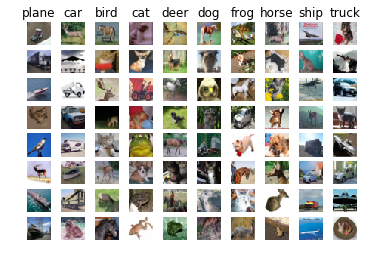

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

In [96]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10


best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code

learning_rates=[2e-1,4e-1,1e-1,1e-2]
batch_sizes=[200]
hidden_sizes=[1000]
learning_rate_decays=[0.95,0.9]
regs=[0.01,0.05]
best_acc= -np.Inf
best_rate=0.0
best_state=None
best_hidden_size=None
best_reg=None
input_size=X_train_feats.shape[1]
batch_size=400
for i in range(len(learning_rates)):
    for j in range(len(regs)):
        for z in range(len(hidden_sizes)):
            for k in range(len(learning_rate_decays)):
                learning_rate_decay=learning_rate_decays[k]
                hidden_size = hidden_sizes[z]
                learning_rate = learning_rates[i]
                reg = regs[j]
                print("learning_rate="+str(learning_rate))
                print("reg="+str(reg))
                print("hidden_size="+str(hidden_size))
                print("learning_rate_decay="+str(learning_rate_decay))
                net = TwoLayerNet(input_size, hidden_size, num_classes)
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=2000, batch_size=batch_size,
                        learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                        reg=reg, verbose=True)
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('Validation accuracy: ', val_acc)
                if  val_acc>best_acc:
                    best_acc=val_acc
                    best_net=net
                    best_rate=learning_rate
                    best_state=stats
                    best_hidden_size=hidden_size
                    best_reg=reg



################################################################################
#                              END OF YOUR CODE                                #
################################################################################

learning_rate=0.2
reg=0.01
hidden_size=1000
learning_rate_decay=0.95
iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 2.143233
iteration 200 / 2000: loss 1.681518
iteration 300 / 2000: loss 1.474064
iteration 400 / 2000: loss 1.452439
iteration 500 / 2000: loss 1.493026
iteration 600 / 2000: loss 1.430757
iteration 700 / 2000: loss 1.418839
iteration 800 / 2000: loss 1.515423
iteration 900 / 2000: loss 1.468062
iteration 1000 / 2000: loss 1.531486
iteration 1100 / 2000: loss 1.405721
iteration 1200 / 2000: loss 1.415605
iteration 1300 / 2000: loss 1.451852
iteration 1400 / 2000: loss 1.477325
iteration 1500 / 2000: loss 1.436900
iteration 1600 / 2000: loss 1.393037
iteration 1700 / 2000: loss 1.419285
iteration 1800 / 2000: loss 1.372113
iteration 1900 / 2000: loss 1.392671
Validation accuracy:  0.536
learning_rate=0.2
reg=0.01
hidden_size=1000
learning_rate_decay=0.9
iteration 0 / 2000: loss 2.302593
iteration 100 / 2000: loss 2.159553
iteration 200 / 2000: loss 1.720334
i

Validation accuracy:  0.511
learning_rate=0.1
reg=0.05
hidden_size=1000
learning_rate_decay=0.95
iteration 0 / 2000: loss 2.302626
iteration 100 / 2000: loss 2.300997
iteration 200 / 2000: loss 2.207732
iteration 300 / 2000: loss 1.970792
iteration 400 / 2000: loss 1.891494
iteration 500 / 2000: loss 1.818637
iteration 600 / 2000: loss 1.808139
iteration 700 / 2000: loss 1.828289
iteration 800 / 2000: loss 1.815764
iteration 900 / 2000: loss 1.781176
iteration 1000 / 2000: loss 1.764952
iteration 1100 / 2000: loss 1.708008
iteration 1200 / 2000: loss 1.810189
iteration 1300 / 2000: loss 1.773481
iteration 1400 / 2000: loss 1.789069
iteration 1500 / 2000: loss 1.741630
iteration 1600 / 2000: loss 1.718116
iteration 1700 / 2000: loss 1.818247
iteration 1800 / 2000: loss 1.791416
iteration 1900 / 2000: loss 1.666963
Validation accuracy:  0.504
learning_rate=0.1
reg=0.05
hidden_size=1000
learning_rate_decay=0.9
iteration 0 / 2000: loss 2.302626
iteration 100 / 2000: loss 2.301483
iteration

In [101]:
print("best_learning_rate:"+str(best_rate))
print("hidden_sizes:"+str(best_hidden_size))
print("best_acc:"+str(best_acc))
print("best_reg:"+str(best_reg))
print("best_decay"+str(best_decay))

best_learning_rate:0.4
hidden_sizes:1000
best_acc:0.57
best_reg:0.01
best_decay0.95


In [98]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.548


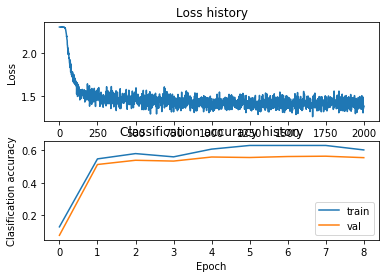

In [99]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_state['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_state['train_acc_history'], label='train')
plt.plot(best_state['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()